###Importing required packages

In [1]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import math

### Data Collection


In [2]:
company = 'AMZN'
key="b745d8e9aa20e20bc27dd040ffbf2ca0f5305244" #insert API token from Tiingo
df = pdr.get_data_tiingo(company, api_key=key)
df.to_csv(company + '.csv')
df=pd.read_csv(company + '.csv')

/usr/local/lib/python3.7/dist-packages/pandas_datareader/tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat(dfs, self._concat_axis)


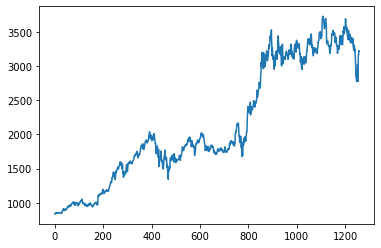

In [3]:
df1 = df.reset_index()['close']
plt.plot(df1)

### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 


In [4]:
#Normalizing the data
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
#Splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
training_size,test_size


(817, 441)

In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

###Importing required libraries

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

### Create the Stacked LSTM model

In [8]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 128)          66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=2)

716/716 - 52s - loss: 0.0014 - 52s/epoch - 73ms/step


In [10]:
#Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

#Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Calculate RMSE performance metrics


In [11]:
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))
#Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

3271.512179648935

### Plotting 

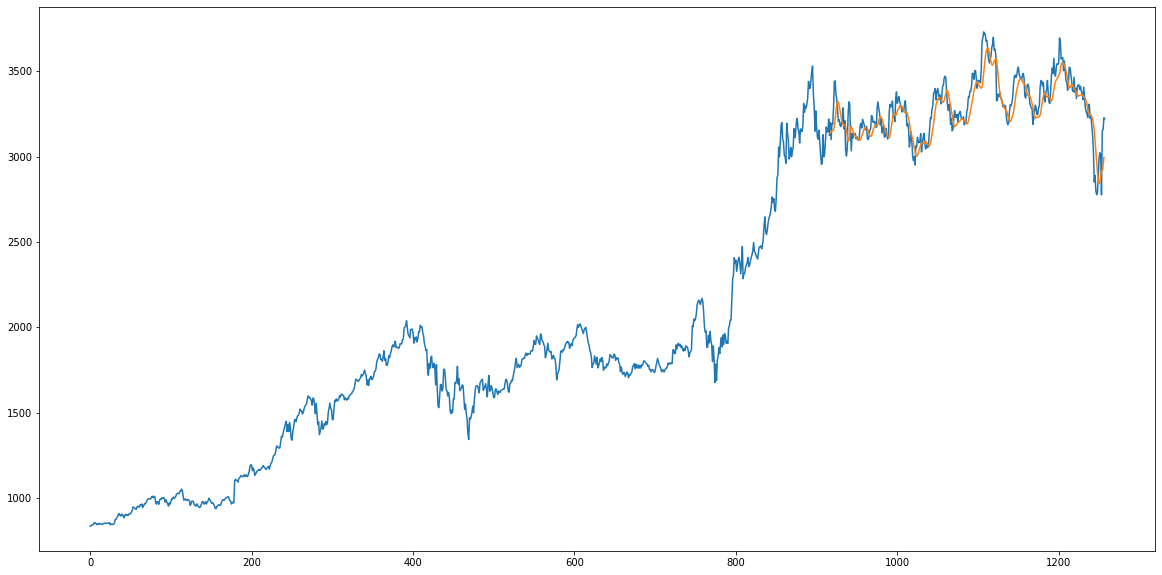

In [12]:
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
rcParams['figure.figsize'] = 20,10
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(df1))
plt.plot(testPredictPlot)
plt.show()

In [13]:
x_input=test_data[341:].reshape(1,-1) 
 
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

###Forecasting stock value for next d days


In [14]:
# demonstrate prediction for next 30 days
from numpy import array
lst_output=[]
n_steps=100
i=0
d=30
while(i<=d):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.78361]
101
1 day output [[0.7922806]]
2 day output [[0.7965657]]
3 day output [[0.7984184]]
4 day output [[0.798874]]
5 day output [[0.7984972]]
6 day output [[0.7976064]]
7 day output [[0.79639095]]
8 day output [[0.7949698]]
9 day output [[0.79342216]]
10 day output [[0.79180324]]
11 day output [[0.79015297]]
12 day output [[0.7885011]]
13 day output [[0.7868687]]
14 day output [[0.7852717]]
15 day output [[0.78372097]]
16 day output [[0.78222364]]
17 day output [[0.780784]]
18 day output [[0.7794038]]
19 day output [[0.7780833]]
20 day output [[0.77682126]]
21 day output [[0.7756156]]
22 day output [[0.7744634]]
23 day output [[0.7733617]]
24 day output [[0.7723073]]
25 day output [[0.7712963]]
26 day output [[0.77032584]]
27 day output [[0.7693924]]
28 day output [[0.7684932]]
29 day output [[0.7676253]]
30 day output [[0.76678634]]


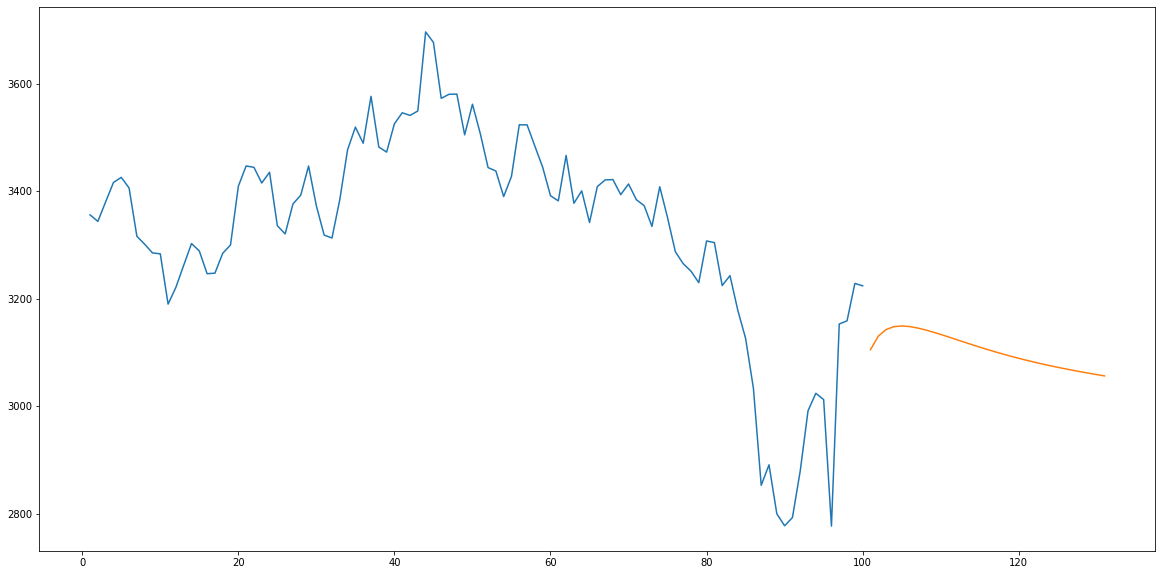

In [15]:
day_new=np.arange(1,101)
day_pred=np.arange(101,132)
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

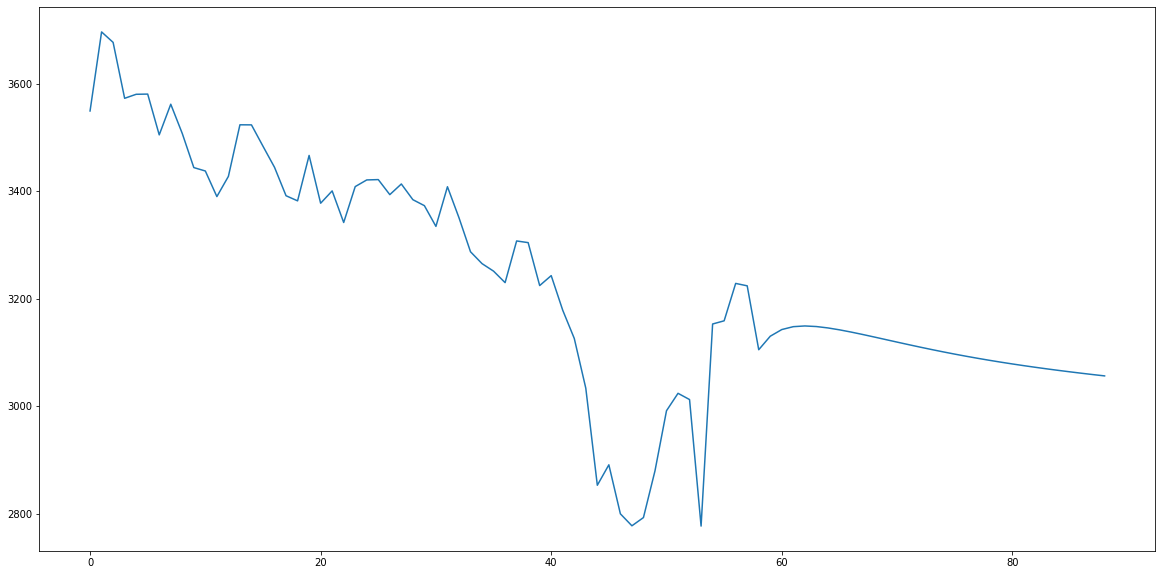

In [16]:
df3=df1.tolist()
df3.extend(lst_output)
#plt.plot(df3[1200:])
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3[1200:])